# FlowMol

FlowMol is an open-source flow matching model for unconditonal de novo generation of small molecules. This notebook demonstrates its capabilities. Check out the [GitHub repository](https://github.com/Dunni3/FlowMol) for more information.

**you must build the flowmol environment as described in the readme before running this notebook**

In [1]:
import flowmol
import py3Dmol

import rdkit
from rdkit import Chem
rdkit.Chem.Draw.IPythonConsole.ipython_3d = True  # enable py3Dmol inline visualization

/home/ian/mambaforge/envs/mol-fm/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.0' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


Load the canonical FlowMol3 model, trained on GEOM-Drugs.

In [2]:
model = flowmol.load_pretrained().cuda().eval()

Sample molecules. This will return a list of `SampledMolecule objects`. A `SampledMolecule` object contains the rdkit molecule in as an attribute, `.rdkit_mol`



3Dmol.js failed to load for some reason. Please check your browser console for error messages.

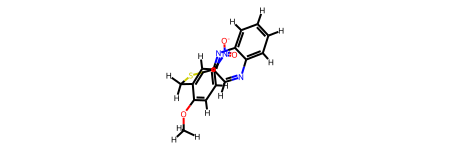

In [3]:
# unfortunately, py3Dmol fails to display any molecule that can't be sanitized by rdkit,
# so this cell may occasionally throw an error
sampled_mols = model.sample_random_sizes(n_molecules=1)
sampled_mols[0].rdkit_mol

In [4]:
def mols_to_sdf(mols, filename):
    sdf_writer = Chem.SDWriter(filename)
    sdf_writer.SetKekulize(False)
    for mol in mols:
        try:
            # Chem.Sanitize
            sdf_writer.write(mol)
        except Exception as e:
            print(e)
            continue
    sdf_writer.close()

sampled_mol = model.sample_random_sizes(n_molecules=1, xt_traj=True, ep_traj=True)[0]

xt_traj_file = 'xt_traj.sdf'
ep_traj_file = 'ep_traj.sdf'
mols_to_sdf(sampled_mol.traj_mols, xt_traj_file)
mols_to_sdf(sampled_mol.ep_traj_mols, ep_traj_file)


# visualize trajectory
view = py3Dmol.view(width=800,height=400, linked=True, viewergrid=(1,2))

for i, filename in enumerate([xt_traj_file, ep_traj_file]):
    with open(filename) as f:
        sdf = f.read()
    view.addModelsAsFrames(sdf, format='sdf', viewer=(0,i))
view.addLabel("current state (gₜ)",{'position':{'x':0,'y':0,'z':0},'useScreen': True, 'fontSize': 24}, viewer=(0,0))
view.addLabel("Predicted final state (ĝ_1 given gₜ)",{'position':{'x':0,'y':0,'z':0},'useScreen': True, 'fontSize': 24}, viewer=(0,1))
view.setStyle({'stick':{}, 'sphere':{'scale': 0.2}},)
view.animate({'loop': 'forward', 'interval': 125},)
view.zoomTo()
view.zoom(0.75)
view.show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

# Compute Metrics on Samples
the following cell samples 100 molecules and computes all of the metrics reported in the paper except for the GFN2-xtb minimization.

In [4]:
from flowmol.analysis.metrics import SampleAnalyzer

analyzer = SampleAnalyzer()
sampled_mols = model.sample_random_sizes(n_molecules=100)
analyzer.analyze(sampled_mols, functional_validity=True, posebusters=True)

Error messages: disconnected: 3, valence: 0, kekulization: 0, other: 0, valid: 100, total: 100
running bosebusters


{'frac_valid_mols': 1.0,
 'avg_frag_frac': 0.9898328267477204,
 'avg_num_components': 1.03,
 'frac_connected': 0.97,
 'frac_atoms_stable': 1.0,
 'frac_mols_stable_valence': 1.0,
 'flag_rate': 0.96,
 'ood_rate': 0.09,
 'reos_cum_dev': 0.6421340564295246,
 'pb_mol_pred_loaded': 1.0,
 'pb_sanitization': 1.0,
 'pb_inchi_convertible': 1.0,
 'pb_all_atoms_connected': 0.97,
 'pb_bond_lengths': 1.0,
 'pb_bond_angles': 1.0,
 'pb_internal_steric_clash': 0.94,
 'pb_aromatic_ring_flatness': 1.0,
 'pb_non-aromatic_ring_non-flatness': 1.0,
 'pb_double_bond_flatness': 0.98,
 'pb_valid': 0.89}